In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/pippahtlin/Extreme-Precipitation/main/data/precipitation_soi_monthly")
df.set_index('date', inplace=True)
df

,year,month,day,monthly rain,binary rain,soi
date,,,,,,
1899-10,1899,10,31,52.324000,1,-1
1899-11,1899,11,30,50.038000,0,-1
1899-12,1899,12,31,59.690000,0,-1
1900-01,1900,1,31,58.928000,0,-1
1900-02,1900,2,28,1.270000,0,-1
...,...,...,...,...,...,...
2022-08,2022,8,31,0.000000,0,1
2022-09,2022,9,30,5.080000,0,1
2022-10,2022,10,31,1.270000,0,1


## 1. EDA

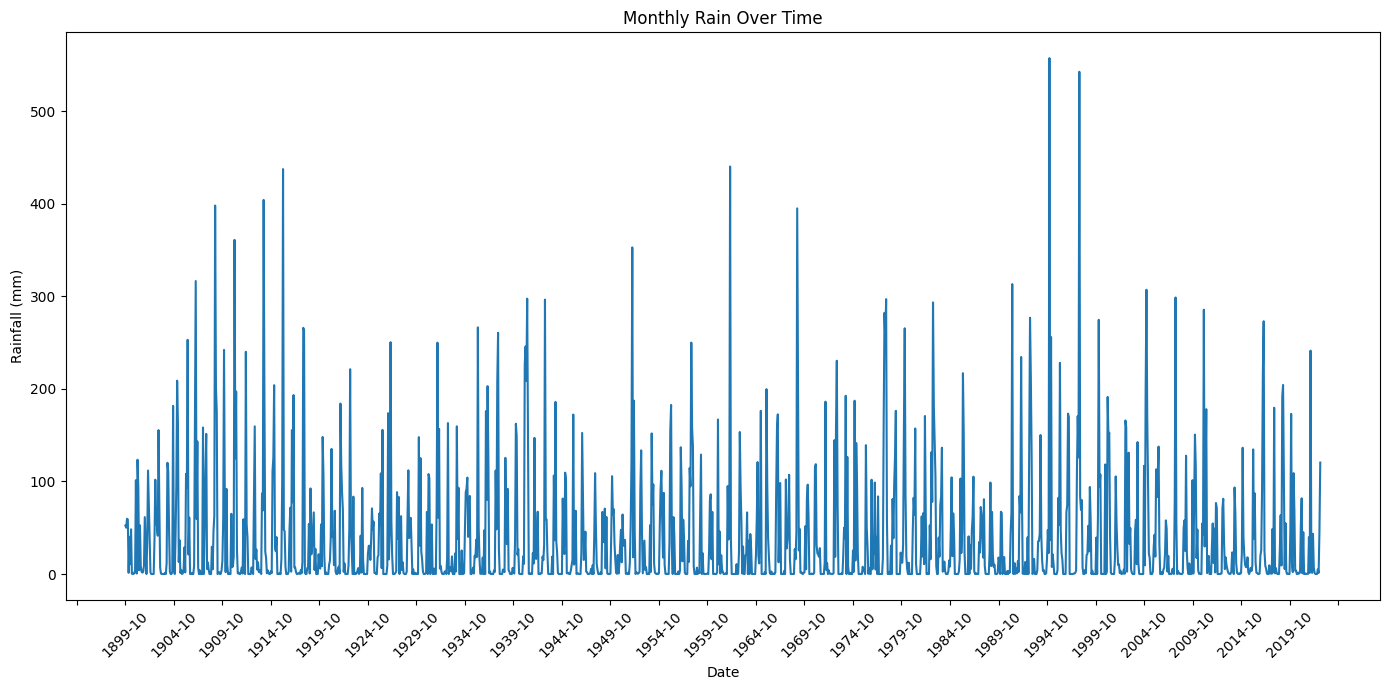

In [4]:
plt.figure(figsize=(14, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=30))

plt.plot(df.index,df['monthly rain'],label = 'Monthly Rain')
plt.title('Monthly Rain Over Time')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()
plt.show()

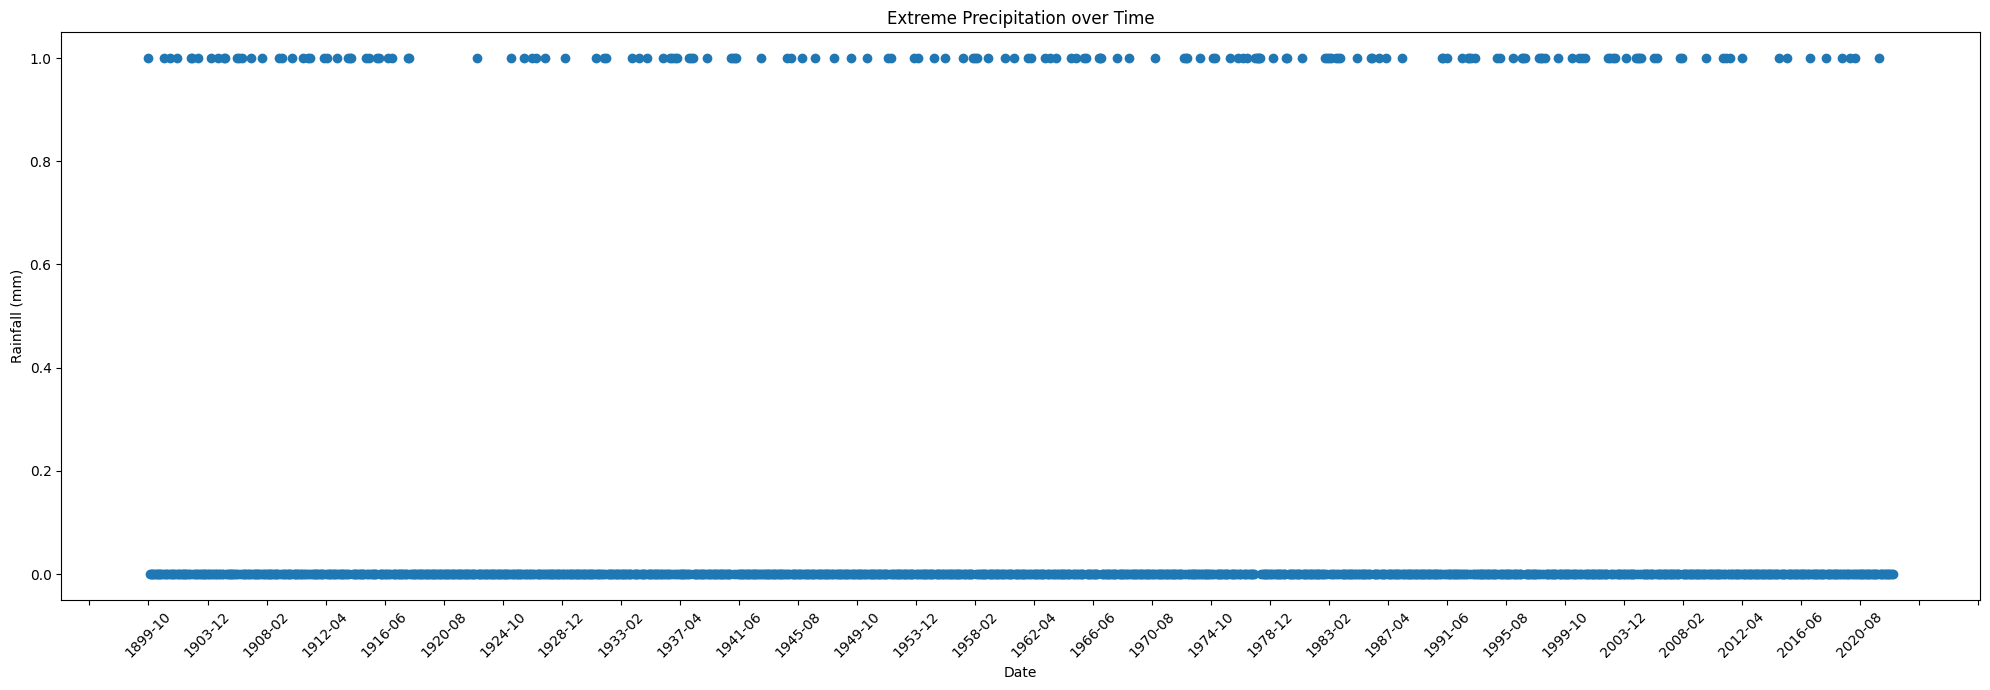

In [5]:
plt.figure(figsize=(20, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))

plt.plot(df.index, df['binary rain'], 'o', label = 'Extreme Precipitation')
plt.title('Extreme Precipitation over Time')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()
plt.show()

In [6]:
months = len(df['binary rain'])
pos_prop = df['binary rain'].sum()/ len(df['binary rain'])
print(f'Number of months: {months}')
print(f'Proportion of extreme precpiptation: {pos_prop}')

Number of months: 1479
Proportion of extreme precpiptation: 0.12102772143340094


<br>

## 2. Split Data
Training set: 70% | Validation set: 15% | Testing set: 15%

In [7]:
# Calculate indices for splitting
total_rows = len(df)
train_end = int(total_rows * 0.7)
validation_end = train_end + int(total_rows * 0.15)

# Using iloc for integer-location based indexing
train_features = df["soi"].iloc[:train_end]
train_rain = df.iloc[:train_end]['binary rain']

validation_features = df["soi"].iloc[train_end:validation_end]
validation_rain = df.iloc[train_end:validation_end]['binary rain']

test_features = df["soi"].iloc[validation_end:]
test_rain = df.iloc[validation_end:]['binary rain']

In [8]:
T = 30 # Consider seasonality

# Prepend the last T-1 observations from the training set to the validation features
prepend_features_to_validation = train_features.iloc[-(T-1):]
validation_features = pd.concat([prepend_features_to_validation, validation_features], axis=0)

# Similarly, prepend the last T-1 observations from the validation set (including the part that was just prepended) to the test features
prepend_features_to_test = validation_features.iloc[-(T-1):]
test_features = pd.concat([prepend_features_to_test, test_features], axis=0)

# Output the shapes of the datasets to check everything is as expected
train_features.shape, train_rain.shape, validation_features.shape, validation_rain.shape, test_features.shape, test_rain.shape

((1035,), (1035,), (250,), (221,), (252,), (223,))

<br>

## 3. Data Preprocessing
Input data for the Keras LSTM layer has 3 dimensions: (M, T, N), where
* M - number of examples (2D: sequences of timesteps x features),
* T - sequence length (timesteps) and
* N - number of features (input_dim)

In [9]:
# Create sequences of T timesteps
X_train, y_train = [], []
for i in range(len(train_rain) - (T-1)):
    X_train.append(train_features.iloc[i:i+T].values)
    y_train.append(train_rain.iloc[i + (T-1)])

X_train, y_train = np.array(X_train), np.array(y_train).reshape(-1,1) # Reshape to vector for model
X_train = X_train[:, :, np.newaxis]
print(f'Train data dimensions: {X_train.shape}, {y_train.shape}')


X_val, y_val = [], []
for i in range(len(validation_rain) - (T-1)):
    X_val.append(validation_features.iloc[i:i+T].values)
    y_val.append(validation_rain.iloc[i + (T-1)])
X_val, y_val = np.array(X_val), np.array(y_val).reshape(-1,1)
X_val = X_val[:, :, np.newaxis]
print(f'Validation data dimensions: {X_val.shape}, {y_val.shape}')

X_test, y_test = [], []
for i in range(len(test_rain)):
    X_test.append(test_features.iloc[i:i+T].values)
    y_test.append(test_rain.iloc[i])
X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1,1)
X_test = X_test[:, :, np.newaxis]

print(f'Test data dimensions: {X_test.shape}, {y_test.shape}')

Train data dimensions: (1006, 30, 1), (1006, 1)
Validation data dimensions: (192, 30, 1), (192, 1)
Test data dimensions: (223, 30, 1), (223, 1)


<br>

## 4. Batch Training and Predictions

In [10]:
# Import Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time

In [11]:
# 1. Make a list of CONSTANTS for modelling:
LAYERS = [30, 30, 30, 1]                # number of units in hidden and output layers (possible tune)
M_TRAIN = X_train.shape[0]           # number of training examples (2D)
M_VAL = X_val.shape[0]           # number of training examples (2D)
M_TEST = X_test.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 30                           # number of epochs (possible tune)
LR = 0.05                            # learning rate of the gradient descent (possible tune)
LAMBD = 0.03                         # lambda in L2 regularizaion (possible tune)
DP = 0.0                             # dropout rate (possible tune)
RDP = 0.0                            # recurrent dropout rate (possible tune)
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')

layers=[30, 30, 30, 1], train_examples=1006, test_examples=223
batch = 1006, timesteps = 30, features = 1, epochs = 30
lr = 0.05, lambda = 0.03, dropout = 0.0, recurr_dropout = 0.0


In [12]:
# Address class imbalanced (assign weight to extreme days)
from sklearn.utils.class_weight import compute_class_weight

# Assuming binary classification and 0 is the majority class
class_weights = compute_class_weight('balanced', classes=[0, 1], y=train_rain)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

In [13]:
# 2. Build the Model
model = Sequential()
model.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='sigmoid'))

In [14]:
# 3. Compile the model with Adam optimizer
model.compile(loss='binary_crossentropy',
              metrics=['accuracy','binary_accuracy',keras.metrics.Precision()],
              optimizer=Adam(learning_rate=LR)) #
print(model.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss',
                             patience=1, verbose=0,
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0,
                           patience=15, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True) # monitor =

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 30)            3840      
                                                                 
 batch_normalization (Batch  (None, 30, 30)            120       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 30, 30)            7320      
                                                                 
 batch_normalization_1 (Bat  (None, 30, 30)            120       
 chNormalization)                                                
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 batch_normalization_2 (Bat  (None, 30)                1

In [15]:
# 4. Train the model.
# The dataset is small for NN - let's use test_data for validation -- should use cross-validation
start = time()
History = model.fit(X_train, y_train,
                    epochs=EPOCH,
                    class_weight=class_weight_dict,
                    batch_size=BATCH,
                    validation_data=(X_val, y_val),
                    shuffle=True,verbose=0,
                    callbacks=[lr_decay, early_stop])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping
-----------------------------------------------------------------
Training was completed in 13.41 secs
-----------------------------------------------------------------


In [19]:
# 5. Evaluate the model:
train_loss, train_accuracy, train_binary_accuracy, train_precision = model.evaluate(X_train, y_train, batch_size=M_TRAIN, verbose=0)
val_loss, val_accuracy, val_binary_accuracy, val_precision = model.evaluate(X_val, y_val, batch_size=M_VAL, verbose=0)

print('-' * 65)
print(f'Train Loss = {train_loss}')
print(f'Train Accuracy = {train_accuracy * 100:.4f}%')
print(f'Train Binary Accuracy = {train_binary_accuracy * 100:.4f}%')
print(f'Train Precision = {train_precision * 100:.4f}%')
print('-' * 65)
print(f'Validation Loss = {val_loss}')
print(f'Validation Accuracy = {val_accuracy * 100:.4f}%')
print(f'Validation Binary Accuracy = {val_binary_accuracy * 100:.4f}%')
print(f'Validation Precision = {val_precision * 100:.4f}%')


-----------------------------------------------------------------
Train Loss = 4.455824375152588
Train Accuracy = 87.9722%
Train Binary Accuracy = 87.9722%
Train Precision = 0.0000%
-----------------------------------------------------------------
Validation Loss = 4.464141368865967
Validation Accuracy = 85.4167%
Validation Binary Accuracy = 85.4167%
Validation Precision = 0.0000%
